**Analyzing Customer Default Payments for Credit Cards**


**Introduction**

This jupyter notebook aims to apply the first steps of CRISP-DM Methodology on a case of Customers Default Payments in Taiwan. The dataset contains data of Gender, Education, Marital status, Payment behaviour and Default.

For the business is critical to predict the default of customers over future periods, that way the business can keep the default under control and improve their approval policies.

In general it would be interesting to find in a Exploratory Data Analysis phase variables related to the target variable (Default). With this in mind I'll be interested in answering the next questions:


1. ***Does men have higher default rates compared to women?** (Just for analysis, this variable isn't allowed to use according to multiple regulatory conventions)*

2. ***The default rates are lower for customers with higher level of education?***

3. ***The delays in payments from previous months are related to default over next menth?***


**Variable Descriptions:**

- LIMIT_BAL: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family 
(supplementary) credit.
- SEX:  (1 = male; 2 = female).
- EDUCATION: Education Level (1 = graduate school; 2 = university; 3 = high school; 4 = others).
- MARRIAGE: Marital status (1 = married; 2 = single; 3 = others).
- AGE: Age of customer (year).
- PAY_0 - PAY_6: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: PAY_0 = the repayment status in September, 2005; PAY_2 = the repayment status in August, 2005; . . .;PAY_6 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
- BILL_AMT1 - BILL_AMT6: Amount of bill statement (NT dollar). BILL_AM1 = amount of bill statement in September, 2005; BILL_AMT2 = amount of bill statement in August, 2005; . . .; BILL_AMT6 = amount of bill statement in April, 2005.
- PAY_AMT1 - PAY_AMT1: Amount of previous payment (NT dollar). PAY_AMT1 = amount paid in September, 2005; PAY_AMT2 = amount paid in August, 2005; . . .;PAY_AMT6 = amount paid in April, 2005.
- DEFAULT: Default Payment


**Preparing the Setup**

In [1]:
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt


**Import and Preview of Data**

According

In [2]:
#The first row contains names like 'X1-X2', second row contains more descriptive names for variables
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls'
#df = pd.read_excel('default of credit card clients.xls',header=1) Reading the file locally
df = pd.read_excel(url,header=1) #Reading the file from the web
df.drop(['ID'],axis=1,inplace=True) #Droping the ID column

print(df.shape) #The dataset contains 30.000 rows and 24 columns 
print(df.head(5)) #Categorical features are stored as numbers

(30000, 24)
   LIMIT_BAL  SEX  EDUCATION  ...  PAY_AMT5  PAY_AMT6  default payment next month
0      20000    2          2  ...         0         0                           1
1     120000    2          2  ...         0      2000                           1
2      90000    2          2  ...      1000      5000                           0
3      50000    2          2  ...      1069      1000                           0
4      50000    1          2  ...       689       679                           0

[5 rows x 24 columns]


**Transforming categorical features for ease the analysis**

Using the documentation of the dataset  [[here]](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#) I map the numbers in categorical features to text for better summaries and plotting without adding extra labels later.

I also change the name of the target because the original is too long. 





In [3]:
#Mapping numbers to their meaning
df['SEX']=df['SEX'].map({1:"male",2:"female"})
df['EDUCATION']=df['EDUCATION'].map({1:"a. graduate school",2:"b. university",3:"c. high school",
                                     4:"d. other",5:"d. other",6:"d. other"})
df['MARRIAGE']=df['MARRIAGE'].map({1:"married",2:"single",3:"other"})

df.rename(columns={'default payment next month': 'DEFAULT'}, inplace=True) #Renaming the target

print(df.dtypes) #The data type for features are OK according to documentation of the dataset

LIMIT_BAL     int64
SEX          object
EDUCATION    object
MARRIAGE     object
AGE           int64
PAY_0         int64
PAY_2         int64
PAY_3         int64
PAY_4         int64
PAY_5         int64
PAY_6         int64
BILL_AMT1     int64
BILL_AMT2     int64
BILL_AMT3     int64
BILL_AMT4     int64
BILL_AMT5     int64
BILL_AMT6     int64
PAY_AMT1      int64
PAY_AMT2      int64
PAY_AMT3      int64
PAY_AMT4      int64
PAY_AMT5      int64
PAY_AMT6      int64
DEFAULT       int64
dtype: object


**There are Missing Values?**

Yes, there are missing values in Education and Marriage variables but the percentage of missing values is low (<2%) so I'll impute the mode in those cases.

In [4]:
df.isna().mean() 
df['EDUCATION'].fillna(df['EDUCATION'].mode()[0],inplace=True)
df['MARRIAGE'].fillna(df['MARRIAGE'].mode()[0],inplace=True)

#Now the dataset has zero missing values


**Summary of  Data**

In [5]:
print(df['SEX'].value_counts(normalize=True))
#There are more women on this dataset (60.3%)

print(df['EDUCATION'].value_counts(normalize=True))
#Majority of customers have a higher level of education

print(df['MARRIAGE'].value_counts(normalize=True))
# There are more single customers than married

print(df.describe().astype(int))
#The average default rate is 22.1%

female    0.603733
male      0.396267
Name: SEX, dtype: float64
b. university         0.468133
a. graduate school    0.352833
c. high school        0.163900
d. other              0.015133
Name: EDUCATION, dtype: float64
single     0.533933
married    0.455300
other      0.010767
Name: MARRIAGE, dtype: float64
       LIMIT_BAL    AGE  PAY_0  PAY_2  ...  PAY_AMT4  PAY_AMT5  PAY_AMT6  DEFAULT
count      30000  30000  30000  30000  ...     30000     30000     30000    30000
mean      167484     35      0      0  ...      4826      4799      5215        0
std       129747      9      1      1  ...     15666     15278     17777        0
min        10000     21     -2     -2  ...         0         0         0        0
25%        50000     28     -1     -1  ...       296       252       117        0
50%       140000     34      0      0  ...      1500      1500      1500        0
75%       240000     41      0      0  ...      4013      4031      4000        0
max      1000000     79      8   

**Question 1**: Does men have higher default rates compared to women?

SEX
female    0.207763
male      0.241672
Name: DEFAULT, dtype: float64
stat=6.927, p=0.000
Rejects H0 so the difference is significative


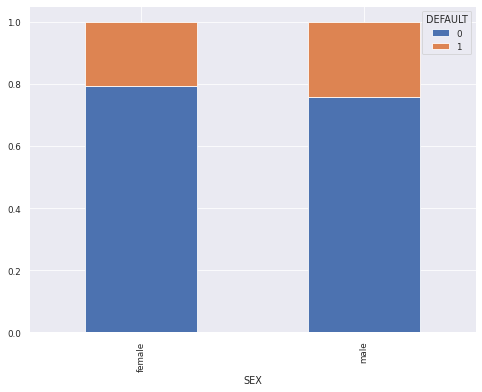

In [13]:
#Setting the style and size of plot
sns.set_theme('paper')
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)

#Plotting 100% stacked bar chart for Sex and Default Level
df.groupby('SEX')['DEFAULT'].value_counts(normalize=True).unstack('DEFAULT').plot.bar(stacked=True,ax=ax)
# Using reference [1], The plot show a little increase in default rate for men

print(df.groupby("SEX").mean()["DEFAULT"])


#The difference looks relevant, but is statistically significant? 

stat, p = ttest_ind(df[(df['SEX']=='male')]['DEFAULT'],
                    df[(df['SEX']=='female')]['DEFAULT'])

print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Can\'t reject H0: mean_1 == mean_2')
else:
	print('Rejects H0 so the difference is significative')

# A: The difference is significant


**Question 2: The default rates are lower for customers with higher level of education?**

EDUCATION           DEFAULT
a. graduate school  0          0.807652
                    1          0.192348
b. university       0          0.762888
                    1          0.237112
c. high school      0          0.748424
                    1          0.251576
d. other            0          0.927313
                    1          0.072687
Name: DEFAULT, dtype: float64
EDUCATION           DEFAULT
a. graduate school  0           8549
                    1           2036
b. university       0          10714
                    1           3330
c. high school      0           3680
                    1           1237
d. other            0            421
                    1             33
Name: DEFAULT, dtype: int64


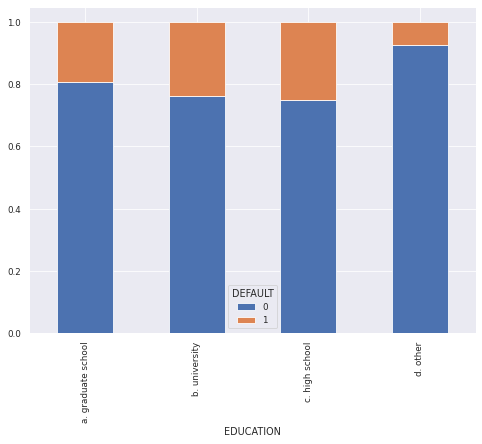

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)

df.groupby('EDUCATION')['DEFAULT'].value_counts(normalize=True).unstack('DEFAULT').plot.bar(stacked=True,ax=ax)
print(df.groupby('EDUCATION')['DEFAULT'].value_counts(normalize=True))
print(df.groupby('EDUCATION')['DEFAULT'].value_counts())

The graduate school representes the highest level of education of customers. In this case it also shows lower level of default compared to University and High School. The lowest level of default is in the "other" category.

**Question 3: The delays in payments from previous months are related to default over next month?**

 Here I use a correlation matrix, another Exploratory Data Analysis technique for understading if there's a correlation between the delays and the Default of customers









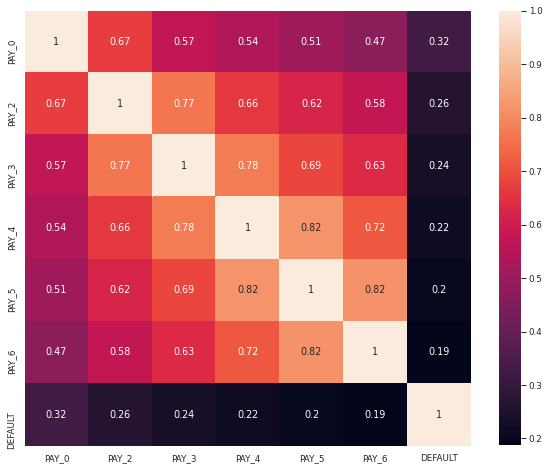

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
delay_and_target = ['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','DEFAULT']
sns.heatmap(df[delay_and_target].corr(), annot=True,ax=ax)


The correlation matrix (or heatmap) shows a weak but consistent correlation between Defaults and delays in payments from previous months. 

**References**


[[1] Stackoverflow: 100% Percentage Stack Barplot](https://stackoverflow.com/questions/64754905/100-stacked-bar-chart-python-seaborn-matplotlib)

[[2] Machine Learning Mastery: Parametric Statistical Significance Tests in  Python](https://machinelearningmastery.com/parametric-statistical-significance-tests-in-python/)